In [1]:
# 주가 Crawling Code
def Crawling_stock( stockItemlist, page ):
    """
    stockItemlist = ['pn풍년','파세코','태양','대륙제관', '라이브플렉스']
    page = 페이지 수
    """
    date=list() 
    name_stock=list()
    close=list() # 종가
    open=list() # 시가
    low=list() # 저가
    high=list() # 고가

    def UrlPath(url): # 내부
        html   = urlopen(url) 
        source = BeautifulSoup(html.read(), "html.parser")
        return source
    
    for stockItem in stockItemlist:
        url = 'http://finance.naver.com/item/sise_day.nhn?code='+ stockItem
        source = UrlPath(url)
        maxPage=source.find_all("table",align="center")
        mp = maxPage[0].find_all("td",class_="pgRR")
        mpNum = int(mp[0].a.get('href')[-3:])

        for page in range(1, page):
            url = 'http://finance.naver.com/item/sise_day.nhn?code=' + stockItem +'&page='+ str(page)
            source = UrlPath(url)
            srlists=source.find_all("tr")
            isCheckNone = None

            if((page % 1) == 0):
                time.sleep(1.50)

            for i in range(1,len(srlists)-1):
                if(srlists[i].span != isCheckNone):
                    if srlists[i].find_all("span",class_="tah p11")[1].text!="0":
                        date.append(srlists[i].find_all("td",align="center")[0].text)
                        close.append(srlists[i].find_all("span",class_="tah p11")[0].text)  # 종가
                        open.append(srlists[i].find_all("span",class_="tah p11")[1].text)   # 시가
                        high.append(srlists[i].find_all("span",class_="tah p11")[2].text)   # 고가
                        low.append(srlists[i].find_all("span",class_="tah p11")[3].text)    # 저가
                        name_stock.append(stockItem)
                    else:
                        date.append(srlists[i].find_all("td",align="center")[0].text)
                        close.append(srlists[i].find_all("span",class_="tah p11")[0].text)  # 종가
                        open.append(srlists[i].find_all("span",class_="tah p11")[2].text)   # 시가
                        high.append(srlists[i].find_all("span",class_="tah p11")[3].text)   # 고가
                        low.append(srlists[i].find_all("span",class_="tah p11")[4].text)    # 저가                 
                        name_stock.append(stockItem)

            if page%70==0:
                print(name_stock[page],close[page],open[page],high[page],low[page])
    df= pd.DataFrame(index=date, data={
                                             'name_stock':name_stock,
                                             'close':close, 
                                             'open':open, 
                                             'low':low,  
                                             'high':high}) 
    return df



# 주가 Crawling Code
def SaveFile( df, fullDstName,  Mode, index, encoding ):
    """
    df = 데이터 프레임
    Mode = 만약 덮어쓰기가 있다면 a , 그냥 생성 w
    fullDstName =  path + 파일 확장자(확장자 주의 요말)
    index = False
    encoding = 인코딩 
    header -> 덮어쓰기에만 적용
    # 2018, 2019, 2020
    """
    if fullDstName.split('.')[1] == 'csv' :
        if Mode == 'a' : 
            # 파일 여부 확인 후 생성 
            if not os.path.exists( fullDstName ):
                df.to_csv( fullDstName , index = index, mode = 'w', encoding = encoding )
            else: 
                df.to_csv( fullDstName , index = index, mode = 'a', encoding = encoding, header = False ) 
        else:
            df.to_csv( fullDstName , index = index, mode = 'w', encoding = encoding )

        
    elif fullDstName.split('.')[1] == 'xlsx' :
        if Mode == 'a' : 
            # 파일 여부 확인 후 생성 
            if not os.path.exists( fullDstName ):
                df.to_xlsx( fullDstName , index = index, mode = 'w', encoding = encoding )
            else: 
                df.to_xlsx( fullDstName , index = index, mode = 'a', encoding = encoding, header = False )
        else:
            df.to_xlsx( fullDstName , index = index, mode = 'w', encoding = encoding )
    else:
        print('Please check your file path! Only, xlsx and csv can use')
        

        
def PageUrl( txt, y, m, d, page ):
    """
    # Page assignment
    from urllib.parse import quote
    page = '11 단위 수치정보' -> 11,21,31 이런식 
    """
    keyword    = quote(txt)
    mainUrl    = f'https://search.naver.com/search.naver?where=news&sm=tab_jum&query={keyword}'

    if page == 1 :
        #  page data
        paramUrl  = f'&sm=tab_opt&sort=0&photo=0&field=0&reporter_article=&pd=3&ds={y}.{m}.{d}&de={y}.{m}.{d}&docid=&nso=so%3Ar%2Cp%3Afrom{y}{m}{d}to{y}{m}{d}%2Ca%3Aall&mynews=0&refresh_start=0&related=0'
        targetUrl = mainUrl + paramUrl
        return targetUrl

    else:
        # Non-page data
        paramUrl  = f'&sm=tab_pge&sort=0&photo=0&field=0&reporter_article=&pd=3&ds={y}.{m}.{d}&de={y}.{m}.{d}&docid=&nso=so:r,p:from{y}{m}{d}to{y}{m}{d},a:all&mynews=0&cluster_rank=32&start={page}&refresh_start=0'
        targetUrl = mainUrl + paramUrl
        return targetUrl


    
def BasicContents( targetUrl ):
    """
    Lightly, 언론사 그리고 큐스 타이틀만 가지고 오기 
    News address  = targetUrl
    """
    try:
        str = requests.get( targetUrl , headers={'User-Agent':'Mozilla/5.0'} )
    except:
        str = requests.get( targetUrl )
    soup    = BeautifulSoup( str.text , 'html.parser' )

    newsTitles = soup.select( '.news .type01 li dt a[title]' )
    step       = soup.select( '.news .type01 li dd ._sp_each_source' )
    
    cmpy = [ tit['title'] for tit in newsTitles ]          # 언론사 
    txt  = [ s.text.split('언론사 선정')[0] for s in step] # 뉴스 타이틀
    
    return cmpy, txt   



def MaxPageCunt( targetUrl ):
    """
    import math 
    # Full viewable page  -> MaxPageCunt( target_url ) 
    """ 
    response = requests.get( targetUrl )
    soup     = BeautifulSoup( response.text, 'html.parser' )
    
    maxPages = soup.find('div',{'class':'title_desc all_my'}) # Total page  
    
    if maxPages != None:
        maxPages = maxPages.find('span').text.split('/')[1].replace('건','').replace(',','').replace(' ','')
        print('maxPages',maxPages )

        # The number of items on the current page
        CurrPagesStep = soup.find('div',{'class':'title_desc all_my'})
        CurrPagesStep = CurrPagesStep.find('span').text.split('/')[0].split('-')[1].replace(' ','').replace(',','')

        CurrPagesStep = int( CurrPagesStep )
        TitPages      = int( maxPages )/4000   # Total Page -> More than 4000 fix it  

        # Page count
        if TitPages >= 1 :  # More than 4000  
            maxPages = 4000
            TitPages = int(int(maxPages)/10)

        else: # 4000 or less 
            TitPages = math.ceil(int(maxPages)/10)
        return CurrPagesStep, TitPages 
    
    else:
        CurrPagesStep = 0
        TitPages      = 0
        return CurrPagesStep, TitPages 
    
     
def StrDate(num):
    """
    # date type change 
    """
    if num >= 10:
        num = str(num)
    else:
        num = "0"+str(num)
    return num


def mkDir(pathName, fileName):
    """
    pathName = 'C:/data/'      # 경로
    fileName = '이름'          # 이름 
    Save Folder Name = pathName, dirname
    """
    path = pathName + fileName
    if not os.path.isdir(path):
        os.makedirs(path)
        targetDir = glob.glob(path)
        print('Folder Created')
    else:
        targetDir = glob.glob(path)
        print('Folder already exist')
        
    return path   


def Main( y, m, d, txt, pathName, fileName):
    """
    # 크롤링 메인 함수 - 1일 기준 
    y = Year m = Month, d = Day, txt = Keyword, pathName = 파일 위치, fileName = output 될 메인파일이름 
    output 파일은 이런 형식으로 {name}_{y}-{m}-{d}' 
    """
    page    = 1
    dic     = {}
    
    mkDir( pathName, fileName ) # 디렉토리 생성 
    
    m = StrDate(m) # Date Type
    d = StrDate(d)
        
    Running = True 
    while Running:
        
        targetUrl      = PageUrl( txt, y, m, d, page )       # targetUrl 
        Titles, Posts  = BasicContents( targetUrl )          # Title, Company name  
        CurrPagesStep, TitPages  = MaxPageCunt( targetUrl )  # Each Count, Total Pages Count
        print(targetUrl) 
        try:
            Titles, Posts = BasicContents( targetUrl )
        except:
            Titles = 'NaN'
            Posts  = 'NaN'

        date = str(y)+'-'+str(m)+'-'+str(d)
        
        dic['Title'] = Titles
        dic['Post']  = Posts
        dic['Date']  = date
        
        df = pd.DataFrame( dic ) # 데이터 프레임 저장 
        
        fullDstName = pathName+'%s.csv'% f'{fileName}/{fileName}_{date}'
        SaveFile(df, fullDstName, 'a', False,  'utf-8-sig') # df, fullDstName,  Mode, index, encoding
        print( '='*20, f'{page}','='*20 )
        page += 10 
        
        #  종료 옵션 
        if page == 4001 :  # Crawling max page 4000!
            Running = False
        elif TitPages == 0 :
            Running = False
        elif page == (TitPages*10)+1:
            Running = False
            
            
def MergeData( pathName, fileName ):
    import pandas as pd
    import glob, os
    """
    # 일단위로 저장 된 데이터를 병합 
    pathName = 'C:/data/' 
    fileName = '이름'
    """
    cnt = 0
    dataList = list()
    path = mkDir( pathName, fileName ) # Dir check func if Do not have dir make it!
    
    for pth in tqdm(glob.glob( path +'/*')):
        origin  = pd.read_csv( pth, index_col = False )
        cnt = cnt + len(origin)
        dataList.append(origin)
        
    CatList= pd.concat( dataList, axis=0, ignore_index = True )
    # data folder dir  Save csv file
    fullDstName =  path +'.csv'
    SaveFile(CatList, fullDstName,'w', False, 'utf-8-sig')
    newPath = glob.glob(pathName+'/*')
    print(cnt)
    
    return newPath


def MakeNouns( pathName, fileName, Contents ):
    """
    만약 Kkma가 설치 되어 있다면 상관없음 
    없으면 설치 권장 
    """
    from konlpy.tag import Kkma
    kkma = Kkma()
    path = pathName + fileName
    df_origin  = pd.read_csv( path + '.csv', index_col=False)
    df = df_origin
    
    df['Keyword'] = None  # 초기값 세팅 
    
    for idx, sen in tqdm(enumerate(Contents)):
        chge   = re.compile('[가-힣. ]+').findall(sen) # 정규식 1차 처리
        nouns  = kkma.nouns( ' '.join(chge) ) # 띄워쓰기 후 명사 추출  
        df['Keyword'][idx] = nouns
        
    fullDstName =  path + '_Keyword.csv'
    SaveFile(df, fullDstName,'w', False, 'utf-8-sig' )    
    
    return print('Finish !')


def TotalStr(Bunch):
    """
    # 리스트안의 중복된 값의 개수
    string 중복값 생성 
    """
    import operator

    oneWords = dict()
    for lst in Bunch:
        try: oneWords[lst] += 1
        except: oneWords[lst]=1

    oneWord = sorted(oneWords.items(),reverse=True, key=operator.itemgetter(1))
    
    return oneWord


# 자동화 함수 - 구글드라이버를 통해 진행
def GetConfirmToken(response):
    """
    # 토큰 받기 
    """
    for key, val in response.cookies.items():
        if key.startswith("download_warning"): #  특정 문자로 시작하는지의 여부
            return val
    return None


def SaveResContent(response, destination ):
    """
    한 번에 하나씩 데이터를 읽어 Chunk라는 덩어리를 만든 후  
    Chunk 단위로 트랜잭션 -> chunkSize별로 묶어서 처리
    """
    chunkSize = 32768
    with open(destination, "wb") as f:
        for chunk in response.iter_content(chunkSize):
            if chunk : 
                f.write(chunk)   

def DownloadFunc(id_, destination):
    """
    # 구글 드라이버를 통해 데이터 자동 다운로드 
    # id_ : 아이디 -> 제공 
    # destination : 경로 = pathName
    """
    baseUrl = "https://docs.google.com/uc?export=download"
    session = requests.Session()
    res   = session.get(baseUrl, params = { 'id' : id_ }, stream = True )
    token = GetConfirmToken(res)
    if token:
        params = { 'id' : id_, 'confirm' : token }
        res    = session.get( baseUrl, params = params, stream = True )
        print(f'성공 : {res}')
    
    print('다운로드 시작')    
    baseName = res.headers['Content-Disposition'].split(';')[1].split('filename=')[1].replace('\"', '')
    fullFileName = path.join( destination, baseName )
    SaveResContent( res, fullFileName )
    print('진행 중 ')
    return fullFileName



def DownloadFromGoogleDrive(fileId, destination):
    """
    # 구글 데이터 다운로드   
    fileId   : id 코드 
    pathName : 다운로드 경로 
    """
    cnt = 0 
    filenameList = list()
    os.makedirs(destination, exist_ok = True)
    try:
        if len(fileId) == 33 and type(fileId) == str :
            download_func = partial( DownloadFunc, destination = pathName )
            print('다운로드 진행중!')
            fileName = DownloadFunc( id_ = fileId, destination = pathName )
            print(f'{fileName} 완료!')
            filenameList.append(fileName)   

        elif type(fileId) == list :
            for key in tqdm(fileId):
                cnt += 1 
                download_func = partial( DownloadFunc, destination = pathName )
                print('다운로드 진행중!')
                fileName = DownloadFunc( id_ = key, destination = pathName )
                print(f'{cnt}번째 {fileName} 완료!')
                filenameList.append(fileName)   
                print('='*60)
        else:
            print(' 33자리 Id 코드가 필요합니다. 확인해 주세요!')    
                
    except Exception as err:
        print(f'{err} : 에러 발생')
        
    return filenameList


def Unzip(filenameList):
    """
    # 압축 해제
    """
    zipFileNameList = [ pathName for pathName in filenameList if pathName.endswith('.zip')]
    for file in tqdm(zipFileNameList):
        print(f'{file} 진행중!')
        with zipfile.ZipFile(file) as targetZip:
            destPath = path.splitext(file)[0]
            os.makedirs(destPath, exist_ok=True)
            targetZip.extractall(destPath)
            print(f'{destPath} 완료!')
        print(f'.zip 파일삭제 {os.remove(file)}') 

In [4]:
import os 
import pandas as pd
import numpy as np
import time
import datetime
import zipfile
from tqdm import tqdm
# import operator
import re,  math  
import glob, sys
import platform

# plotly for Visualization
import plotly.io as pio
pio.renderers.default = 'notebook_connected'
import plotly
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings(action='ignore')

# Crawling
import requests
import urllib
from urllib.parse import quote
from urllib.request import urlopen
from bs4 import BeautifulSoup

# Wordcloud
from wordcloud import WordCloud
from wordcloud import ImageColorGenerator

# wordcloud_graph show 
import matplotlib.pyplot as plt  
import seaborn as sns
%matplotlib inline

# Natural Language Processing
import nltk 
from konlpy.tag import *
kkma = Kkma()

# donwload
import os 
import os.path as path
import requests
from multiprocessing import Pool
from functools import partial

In [6]:
# 데이터 다운로드 
fileId   = [ '1emS3CMUyd4EGLL6BGVzIAzjIYy6EO0QJ',  # 데이콘 제공데이터
            '1it_tfbavyxyJCa6-Qk7VAT_3cQbqvugt' ] # 수집데이터          
pathName = f'C:/Users/pleasure/학과공모전' # 사용자가 원하는 경로
# 다운로드 후 압축 해제
filenameList = DownloadFromGoogleDrive(fileId, pathName)
Unzip(filenameList)

# 다운로드 확인 
dirPath = os.listdir(pathName)
dirPath


  0%|          | 0/2 [00:00<?, ?it/s]

다운로드 진행중!
성공 : <Response [200]>
다운로드 시작
진행 중 
1번째 C:/Users/pleasure/학과공모전\KT_data_20200717.zip 완료!



 50%|█████     | 1/2 [03:16<03:16, 196.92s/it]

다운로드 진행중!
성공 : <Response [200]>
다운로드 시작
진행 중 
2번째 C:/Users/pleasure/학과공모전\DataMiners.zip 완료!



100%|██████████| 2/2 [04:53<00:00, 166.78s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

C:/Users/pleasure/학과공모전\KT_data_20200717.zip 진행중!
C:/Users/pleasure/학과공모전\KT_data_20200717 완료!
.zip 파일삭제 None



 50%|█████     | 1/2 [00:29<00:29, 29.98s/it]

C:/Users/pleasure/학과공모전\DataMiners.zip 진행중!
C:/Users/pleasure/학과공모전\DataMiners 완료!
.zip 파일삭제 None



100%|██████████| 2/2 [00:35<00:00, 22.71s/it]


['.ipynb_checkpoints',
 '20201029황혼까지 분석.ipynb',
 'DataMiners',
 'KT_data_20200717',
 '로밍 19,20 02~08',
 '유동인구 19,20 03~08',
 '통화 20 02~08']

In [11]:
print('\t',"<< 제공받은 데이터셋 >> ",'\n', np.array(glob.glob(pathName+'KT_data_20200717/*')))

	 << 제공받은 데이터셋 >>  
 ['C:/Users/pleasure/학과공모전/KT_data_20200717\\adstrd_master.csv'
 'C:/Users/pleasure/학과공모전/KT_data_20200717\\card_20200717.csv'
 'C:/Users/pleasure/학과공모전/KT_data_20200717\\COVID_19'
 'C:/Users/pleasure/학과공모전/KT_data_20200717\\COVID_eng_kor_table.xlsx'
 'C:/Users/pleasure/학과공모전/KT_data_20200717\\delivery.csv'
 'C:/Users/pleasure/학과공모전/KT_data_20200717\\fpopl.csv'
 'C:/Users/pleasure/학과공모전/KT_data_20200717\\index.csv']


제공 데이터 셋       
행정통 코드 데이터     
업종 별 결제액 데이터        
월간데이콘 코로나 데이터      
배달 호출 정보 데이터       
품목 별 소비지수 데이터    

In [14]:
print('\t',"<< 크롤링 데이터셋 >> ",'\n', np.array(glob.glob(pathName + dirPath[2] +"/*")))

	 << 크롤링 데이터셋 >>  
 ['C:/Users/pleasure/학과공모전/DataMiners\\camping_jun_keyword.xlsx'
 'C:/Users/pleasure/학과공모전/DataMiners\\CampLastYear_Keyword.csv'
 'C:/Users/pleasure/학과공모전/DataMiners\\Camp_add_score.csv'
 'C:/Users/pleasure/학과공모전/DataMiners\\Camp_Keyword.csv'
 'C:/Users/pleasure/학과공모전/DataMiners\\datalab_3year.xlsx'
 'C:/Users/pleasure/학과공모전/DataMiners\\Haengjeong_beobjeongdong.xlsx'
 'C:/Users/pleasure/학과공모전/DataMiners\\jdk-8u211-windows-x64.exe'
 'C:/Users/pleasure/학과공모전/DataMiners\\policy_edit.csv'
 'C:/Users/pleasure/학과공모전/DataMiners\\README.md'
 'C:/Users/pleasure/학과공모전/DataMiners\\requirements.txt'
 'C:/Users/pleasure/학과공모전/DataMiners\\stock.csv'
 'C:/Users/pleasure/학과공모전/DataMiners\\tour.csv'
 'C:/Users/pleasure/학과공모전/DataMiners\\tour_add_score.csv']


캠핑 관련 데이터들   
캠핑 관련 주가 데이터  

In [15]:
# 제공 받은 데이터 로드
card_origin  = pd.read_csv( pathName + dirPath[3] +"/" + "card_20200717.csv") #데이터 수정 필요 
fpopl_origin = pd.read_csv( pathName + dirPath[3] +"/" + "fpopl.csv")
policy       = pd.read_csv( pathName + dirPath[2] +"/" + "policy_edit.csv") # 제공 policy 기반 
Time         = pd.read_csv( pathName + dirPath[3] +"/" + "COVID_19/Time.csv")

# 크롤링을 통해 생성한 데이터프레임 로드
key_com      = pd.read_excel(pathName + dirPath[2] +"/" + "camping_jun_keyword.xlsx")
keyword      = pd.read_excel(pathName + dirPath[2] +"/" + "datalab_3year.xlsx",header=0)

사용한 데이터  
카드 데이터  
유동인구 데이터  
정책 및 시간 데이터  

카드 데이터를 먼저 전처리 하였음.  
무슨 데이터를 먼저 봐야하나  
왜 먼저 카드 데이터를 봤을까?   

In [16]:
card = card_origin

# 결측치를 제거합니다
err_values = ["석재", "커텐", "영상물", "복지매장", "축협직영매장"]

for err_value in err_values:
    card = card.drop( card[card["selng_cascnt"] == err_value].index )

# 구매건수와 구매총액이 string type이었기 때문에 바꿔줍니다
card["selng_cascnt"] = card["selng_cascnt"].astype("int64") 
card["salamt"] = card["salamt"].astype("int64") 

# 날짜 데이터가 int type이기 때문에 datetime으로 바꿔줍니다
card["receipt_dttm"] = pd.to_datetime(card["receipt_dttm"], format="%Y%m%d")

# 군집별로 분석하기 위해 군집 코드를 추가해줍니다.
card['mrhst_induty_cl_code'] = card['mrhst_induty_cl_code'].astype(str)
card['mrhst_induty_clm_code'] = card['mrhst_induty_cl_code'].str.slice(start=0, stop=2)

# 보기 쉽게 순서를 정리합니다
card = card[['receipt_dttm',  'adstrd_code', 'adstrd_nm','mrhst_induty_clm_code', 'mrhst_induty_cl_code',
       'mrhst_induty_cl_nm', 'selng_cascnt', 'salamt']]

# 띄워쓰기가 여러 개인 경우가 있어서 모든 value의 띄워쓰기를 제거해줍니다
card.mrhst_induty_cl_nm = card.mrhst_induty_cl_nm.str.replace(' ', '')

# Time 데이터 일별 확진자 수를 구해줍니다
Time["shifted"] = Time.confirmed.shift(1)
Time['daily']   = Time.confirmed - Time.shifted
# 확인
card.head()

,receipt_dttm,adstrd_code,adstrd_nm,mrhst_induty_clm_code,mrhst_induty_cl_code,mrhst_induty_cl_nm,selng_cascnt,salamt
0,2020-01-04,1174066000,성내3동,70,7041,약국,463,5843230
1,2020-01-04,1174066000,성내3동,70,7022,치과의원,33,7835550
2,2020-01-04,1174066000,성내3동,70,7021,한의원,53,4589800
3,2020-01-04,1174066000,성내3동,70,7020,의원,339,9267240
4,2020-01-04,1174066000,성내3동,61,6110,자동차정비,19,4441000


mrhst_induty_cl_code열이 250개의 업종을 담고 있음  
하지만 code의 앞 두글자가 대부분 비슷한 업종을 담고 있음  
따라서 35개 중분류를 두는 열을 만들었음  
   
      
일별 확진자를 구하기 위해서 누적합이므로  
전날 값을 빼주었음  

In [17]:
keyword["날짜"] = pd.to_datetime(keyword.날짜, format="%Y-%m-%d")
key_com = key_com.drop(index = key_com[key_com["월간검색수(PC)"]=='< 10'].index)
# 클릭수가 3자리 ,로 구분되어 있어 object타입입니다. 콤마를 제거하고 interger로 타입을 바꿔줍니다.
key_com["월평균클릭수(PC)"] = key_com["월평균클릭수(PC)"].str.replace(",","")
key_com["월평균클릭수(PC)"] = key_com["월평균클릭수(PC)"].str.replace(" ","")

key_com["월평균클릭수(PC)"] = key_com["월평균클릭수(PC)"].astype("float64")

key_com["월평균클릭수(모바일)"] = key_com["월평균클릭수(모바일)"].str.replace(",","")
key_com["월평균클릭수(모바일)"] = key_com["월평균클릭수(모바일)"].str.replace(" ","")
key_com["월평균클릭수(모바일)"] = key_com["월평균클릭수(모바일)"].astype("float64")

# 월평균클릭수PC와 모바일을 합쳐 월평균클릭수(전체)라는 컬럼을 만들어줍니다.
key_com["월평균클릭수(전체)"] = key_com["월평균클릭수(PC)"] + key_com["월평균클릭수(모바일)"]
# 월평균클릭수(전체)로 내림차순합니다.
key_com.sort_values(by="월평균클릭수(전체)", ascending=False, inplace=True)
key_com["월평균클릭수(전체)"] = key_com["월평균클릭수(전체)"].astype(int)

key_com = key_com[["연관키워드","월평균클릭수(PC)", "월평균클릭수(모바일)","월평균클릭수(전체)"]]

In [18]:
fig = make_subplots(
                    rows  = 2, 
                    cols  = 1,
                    specs = [ [{}],
                             [{"type":"table"}]],
                    subplot_titles   = (
                                        "<b>일별 확진자 수 추이<b>",
                                        "<b>정책 테이블<b>"),
                    vertical_spacing = 0.15
)

fig.add_trace(
    go.Bar( 
            x = Time.date, 
            y = Time.daily,
            name = '일별 확진자 수', 
            marker_color='red',
            hovertemplate= '<i>일일 확진자 수</i>=%{y:,f}'+'명'
    ), 
    row = 1 ,
    col = 1
)

fig.add_trace(
        go.Table(
            columnorder = [1,2],
            columnwidth = [80,400],
            header=dict(
                        values=["date", "Corona issue"],
                        font=dict(size=10),
                        align="center"
                    ),
            cells=dict(
                        values=[policy[k].tolist() for k in policy.columns[0:]],
                        align = "center"),
                    ),
            row=2 ,col=1
)

fig.update_layout(  width = 800,
                    shapes=[
                            dict(
                                fillcolor = "#F37859",
                                line = dict( width = 0 ),
                                type = "rect",
                                x0   = "2020-03-01",
                                x1   = "2020-06-30",
                                xref = "x1",
                                y0   =  0.575,
                                y1   =  1,
                                yref = "paper",
                                opacity = 0.2)
                    ]
                )

### 데이터프레임 생성 월별

In [24]:
# receipt_dttm 컬럼을 string type으로 변경 후 Month만 가지고와서 receipt_dttm_month 컬럼을 만들어 추가해 줍니다.
clm = card
clm.receipt_dttm = clm.receipt_dttm.astype(str)
clm["receipt_dttm_month"] = clm.receipt_dttm.str.split(pat="-").str[1]
clm.receipt_dttm = pd.to_datetime(clm.receipt_dttm, format="%Y-%m-%d")

# 군집별, 월별로 구매 건수와 구매 총액의 평균을 구합니다.
clm = clm.groupby(by=["receipt_dttm_month", "mrhst_induty_clm_code"])["selng_cascnt","salamt"].mean()
clm = clm.reset_index()
clm["selng_cascnt"] = clm["selng_cascnt"].astype("int64")
clm["salamt"] = clm["salamt"].astype("int64")

# 35개의 군집이 * 6개월치 들어있기 때문에 (210, 4)의 shape을 가집니다.
clm.head()

,receipt_dttm_month,mrhst_induty_clm_code,selng_cascnt,salamt
0,01,10,52,5803222
1,01,11,9349,151520433
2,01,20,42,4476188
3,01,21,71,1135277
4,01,22,53,1257025


월별로 35개 군집의 평균 판매 액수 및 평균 판매량을 구함  

In [25]:
# 군집들을 달 별로 비교하여 증감추이를 살펴보겠습니다.
# 먼저 달 별로 filter를 실행합니다. (2월, 3월, 4월, 5월)
Feb = clm[clm["receipt_dttm_month"] == "02" ].sort_values(by="mrhst_induty_clm_code")
Feb.index = pd.RangeIndex(len(Feb.index))
Mar = clm[clm["receipt_dttm_month"] == "03" ].sort_values(by="mrhst_induty_clm_code")
Mar.index = pd.RangeIndex(len(Mar.index))
Apr = clm[clm["receipt_dttm_month"] == "04" ].sort_values(by="mrhst_induty_clm_code")
Apr.index = pd.RangeIndex(len(Apr.index))
May = clm[clm["receipt_dttm_month"] == "05" ].sort_values(by="mrhst_induty_clm_code")
May.index = pd.RangeIndex(len(May.index))

# 군집코드와 구매건수, 구매총액 별로 증감률이 담길 데이터프레임을 생성해줍니다.
GR = pd.DataFrame( columns=[ "mrhst_induty_clm_code", "Mar_cnt_GR","Apr_cnt_GR","May_cnt_GR",
                                                      "Mar_amt_GR","Apr_amt_GR","May_amt_GR" ] )

GR["mrhst_induty_clm_code"] = clm["mrhst_induty_clm_code"].unique()
# 군집별 구매건수와 구매총액에 대한 증감률을 구합니다
# 증감률 = (당월/전월)*100 입니다

GR["Mar_cnt_GR"] = (Mar["selng_cascnt"]/Feb["selng_cascnt"])*100
GR["Apr_cnt_GR"] = (Apr["selng_cascnt"]/Mar["selng_cascnt"])*100
GR["May_cnt_GR"] = (May["selng_cascnt"]/Apr["selng_cascnt"])*100

GR["Mar_amt_GR"] = (Mar["salamt"]/Feb["salamt"])*100
GR["Apr_amt_GR"] = (Apr["salamt"]/Mar["salamt"])*100
GR["May_amt_GR"] = (May["salamt"]/Apr["salamt"])*100

GR["mrhst_induty_clm_code"] = GR["mrhst_induty_clm_code"].astype(str)

# 증감률이 100이상인 것(전월 대비 성장한)만 추출합니다

Mar = GR[GR["Mar_cnt_GR"]>100].sort_values(by="Mar_cnt_GR", ascending=False)
Apr = GR[GR["Apr_cnt_GR"]>100].sort_values(by="Apr_cnt_GR", ascending=False)
May = GR[GR["May_cnt_GR"]>100].sort_values(by="May_cnt_GR", ascending=False)

Mar = Mar["mrhst_induty_clm_code"].tolist()
Apr = Apr["mrhst_induty_clm_code"].tolist()
May = May["mrhst_induty_clm_code"].tolist()

incres = Mar + Apr + May

# 증감률이 100 이상이면서 2번 이상 100이상인 품목을 추출합니다 Ex) 3월, 5월 증감률 100 이상
incre_cnt = dict() 

for incre in incres: 
    if incre not in incre_cnt.keys(): 
        incre_cnt[incre] = 1 
    else: 
        incre_cnt[incre] += 1

for key,value in incre_cnt.items():
    if value >=2:
        print("\n군집코드 : ", key)
        print("품목 : \n".format(key), 
              card[card["mrhst_induty_clm_code"]=="{}".format(key)]["mrhst_induty_cl_nm"].unique())


군집코드 :  95
품목 : 
 ['통신판매(일반)' '통신판매(생활서비스)']

군집코드 :  31
품목 : 
 ['가전제품' '기타전기제품' '냉열기기']

군집코드 :  96
품목 : 
 ['농기계' '비료/농약/사료/종자' '기타농업관련']

군집코드 :  92
품목 : 
 ['세탁소' '사무통신기기수리' '가정용품수리' '기타수리서비스' '신변잡화수리' '레져용품수리']

군집코드 :  20
품목 : 
 ['스포츠레져용품' '골프용품' '악기점' '피아노대리점' '총포류판매']

군집코드 :  70
품목 : 
 ['약국' '치과의원' '한의원' '의원' '동물병원' '병원' '종합병원' '한약방' '기타의료기관및기타의료기기' '치과병원'
 '산후조리원' '한방병원' '제약회사' '건강진단' '조산원']

군집코드 :  83
품목 : 
 ['기타음료식품' '농축수산품' '정육점' '제과점' '주류판매점' '미곡상']

군집코드 :  42
품목 : 
 ['정장' '내의판매점' '기타의류' '스포츠의류' '맞춤복점' '아동의류' '양품점' '단체복' '와이셔츠/타이' '캐쥬얼의류']

군집코드 :  52
품목 : 
 ['기타사무용품' '통신기기' '전자(상우회)' '컴퓨터' '사무기기' '통신기기무이자할부']

군집코드 :  61
품목 : 
 ['자동차정비' '주차장' '자동차부품' '자동차시트/타이어' '윤활유전문판매' '세차장' '카인테리어' '견인서비스'
 '국산신차직영부품/정비업소' '기타자동차서비스' '중장비수리']

군집코드 :  11
품목 : 
 ['관광여행' '택시' '항공사' '렌트카' '여객선' '기타교통수단' '고속버스' '철도' '택시회사']

군집코드 :  80
품목 : 
 ['스넥' '주점' '서양음식' '중국음식' '일식회집' '일반한식' '칵테일바' '위탁급식업' '갈비전문점' '한정식']

군집코드 :  62
품목 : 
 ['손해보험' '생명보험' '기타보험']

군집코드 :  33
품목 : 
 ['주유소' '유류판매' 'L

In [26]:
GR = GR[(GR["mrhst_induty_clm_code"] == str(61)) | 
        (GR["mrhst_induty_clm_code"] == str(31)) | 
        (GR["mrhst_induty_clm_code"] == str(20)) | 
        (GR["mrhst_induty_clm_code"] == str(33)) | 
        (GR["mrhst_induty_clm_code"] == str(11)) | 
        (GR["mrhst_induty_clm_code"] == str(83)) | 
        (GR["mrhst_induty_clm_code"] == str(52)) | 
        (GR["mrhst_induty_clm_code"] == str(95)) | 
        (GR["mrhst_induty_clm_code"] == str(96)) | 
        (GR["mrhst_induty_clm_code"] == str(42)) | 
        (GR["mrhst_induty_clm_code"] == str(80)) | 
        (GR["mrhst_induty_clm_code"] == str(40)) | 
        (GR["mrhst_induty_clm_code"] == str(62)) | 
        (GR["mrhst_induty_clm_code"] == str(70)) | 
        (GR["mrhst_induty_clm_code"] == str(50)) |
        (GR["mrhst_induty_clm_code"] == str(92)) |
        (GR["mrhst_induty_clm_code"] == str(10)) ]

# 구매건수와 구매총액의 평균 성장률을 보기위해 컬럼을 추가해줍니다.
GR["cnt_GR_avg"] = (GR["Mar_cnt_GR"]+GR["Apr_cnt_GR"]+GR["May_cnt_GR"])/300
GR["amt_GR_avg"] = (GR["Mar_amt_GR"]+GR["Apr_amt_GR"]+GR["May_amt_GR"])/300
GR = GR.sort_values(by="cnt_GR_avg", ascending=False)

# 상위 10개만 slicing 해줍니다.
GR = GR[:10]

GR

,mrhst_induty_clm_code,Mar_cnt_GR,Apr_cnt_GR,May_cnt_GR,Mar_amt_GR,Apr_amt_GR,May_amt_GR,cnt_GR_avg,amt_GR_avg
32,95,221.069588,95.482367,100.915751,197.834410,77.139685,102.221377,1.391559,1.257318
33,96,125.000000,140.000000,114.285714,80.380711,131.572003,73.416882,1.264286,0.951232
2,20,105.882353,116.666667,133.333333,94.145761,120.467890,121.568376,1.186275,1.120607
6,31,141.176471,104.166667,100.000000,108.279864,101.162063,120.435914,1.151144,1.099593
12,42,86.666667,123.076923,131.250000,87.871574,115.833402,119.966431,1.136645,1.078905
17,52,100.000000,118.181818,107.692308,87.095450,107.720469,89.391878,1.086247,0.947359
30,92,108.333333,100.000000,107.692308,108.211783,106.012863,103.040709,1.053419,1.057551
1,11,98.567548,110.448509,105.807623,70.424273,117.064501,118.753220,1.049412,1.020807
21,70,104.597701,106.593407,98.969072,80.321107,115.445591,101.520239,1.033867,0.990956
26,83,101.020408,104.040404,103.883495,98.531656,102.366265,107.521551,1.029814,1.028065


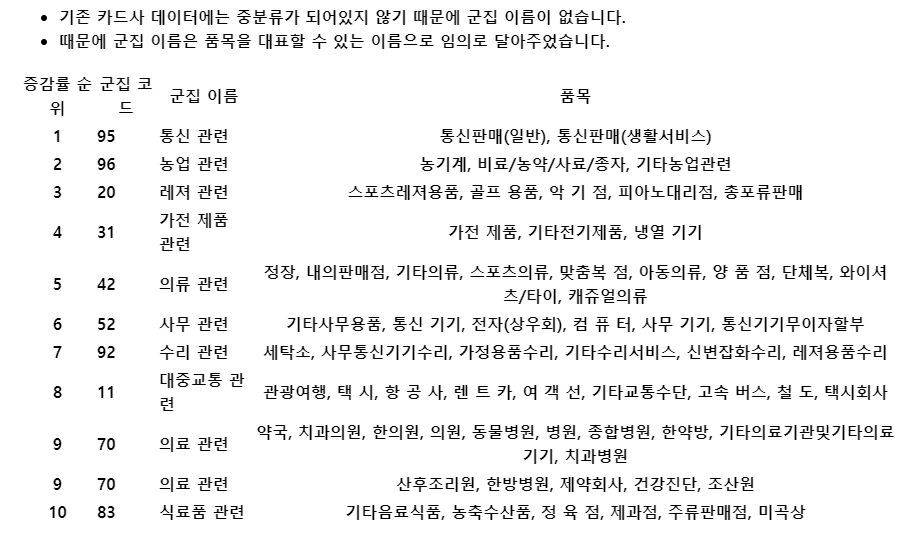

## 증감률이 높은 상위 10개 군집의 월별 증감률 시각화

In [27]:
template = "ggplot2"
fig = make_subplots(specs=[[{}]])

# Add traces
fig.add_trace(
    go.Bar( 
            x=GR.mrhst_induty_clm_code.tolist(), 
            y=GR.cnt_GR_avg, 
            name="월별 구매건수<br> 증감률 TOP10",
            marker_color='#A9B5F4', 
            text=round(GR.cnt_GR_avg-1,2),
            textposition="outside",
            texttemplate='%{text:%}',
            textfont=dict(size=13, color='black')
    )
)

fig.add_trace(
    go.Bar( 
            x=GR.mrhst_induty_clm_code.tolist(), 
            y=GR.amt_GR_avg, 
            name="월별 구매총액<br> 증감률 TOP10",
            marker_color='#5456BD',
            text=round(GR.amt_GR_avg-1,2),
            textposition="outside",
            texttemplate='%{text:%}',
            textfont=dict(size=13, color='black')
    )
)

# Set x-axis
fig.update_xaxes(title_text="")

# Set y-axis
fig.update_yaxes(   
                showgrid=True,
                tickvals = [1, 1.2, 1.4],
                ticktext=["0%","20%","40%"])

# Set layout
fig.update_layout(  
                height     = 600, 
                width      = 800,
                template   = "ggplot2",
                title_text = "<b>월별 구매건수, 총액 증감률이 높은 군집 TOP10<b>", 
                title_x    = 0.25, 
                font       = dict( size=14, color='#665A59'),
                xaxis_type ='category',
                xaxis      = dict( 
                tickvals   = GR.mrhst_induty_clm_code.unique(),
                ticktext   = [ "통신판매","농업","레져용품","가전제품",
                               "의류","통신기기","수리","대중교통","의료","식품" ]
                ),
               # line 삽입
               shapes=[ 
                        dict(
                            type = 'line', 
                            yref = 'paper', 
                            y0   = 0.683, 
                            y1   = 0.683,
                            xref = 'x',     
                            x0   = -0.5, 
                            x1   = 9.5,
                            line = dict(
                                        color = "Red",
                                        width = 1,
                                        dash  = "dashdot",
                )
           ) 
      ]
)


fig.show()

통신 판매, 통신기기에서 비대면이라 증가폭이 있었다.  
농업에서 구매 건수는 늘었지만 구매 평균액은 낮아졌다.  
레저용품, 의류, 대중교통의 소비가 비대면인데도 불구하고 늘어났다.  

레저나 의류 대중교통이 왜 늘어났을까?  
질문을 가지게 되었음

## 따라서 세가지 category를 조금 더 자세히 살펴봄 

In [28]:
# card 데이터셋에서 3개의 군집만 filtering합니다.
cl_nm = card[ (card["mrhst_induty_clm_code"]=="11") |
              (card["mrhst_induty_clm_code"]=="20") |
              (card["mrhst_induty_clm_code"]=="42") ]

# 날짜를 string으로 변환 후 split하여 month를 추출해준 후 다시 datetime type으로 바꿔줍니다
cl_nm.receipt_dttm = cl_nm.receipt_dttm.astype(str)
cl_nm["receipt_dttm_month"] = cl_nm.receipt_dttm.str.split(pat="-").str[1]
cl_nm.receipt_dttm = pd.to_datetime(cl_nm.receipt_dttm, format="%Y-%m-%d")

# 월별로 분류코드 별로 구매 건수와 구매 총액의 평균을 구합니다.
cl_nm = cl_nm.groupby(by=["receipt_dttm_month", "mrhst_induty_cl_nm"])["selng_cascnt","salamt"].mean()
cl_nm = cl_nm.reset_index()
cl_nm["selng_cascnt"] = cl_nm["selng_cascnt"].astype("int64")
cl_nm["salamt"] = cl_nm["salamt"].astype("int64")

# 달 별로 filter를 실행합니다.
Feb = cl_nm[cl_nm["receipt_dttm_month"] == "02" ].sort_values(by="mrhst_induty_cl_nm")
Feb.index = pd.RangeIndex(len(Feb.index))
Mar = cl_nm[cl_nm["receipt_dttm_month"] == "03" ].sort_values(by="mrhst_induty_cl_nm")
Mar.index = pd.RangeIndex(len(Mar.index))
Apr = cl_nm[cl_nm["receipt_dttm_month"] == "04" ].sort_values(by="mrhst_induty_cl_nm")
Apr.index = pd.RangeIndex(len(Apr.index))
May = cl_nm[cl_nm["receipt_dttm_month"] == "05" ].sort_values(by="mrhst_induty_cl_nm")
May.index = pd.RangeIndex(len(May.index))

# 품목의 이름과 구매건수, 구매총액 별로 증감률이 담길 데이터프레임을 생성해줍니다.
GR = pd.DataFrame( columns=[ "mrhst_induty_cl_nm", "Mar_cnt_GR","Apr_cnt_GR","May_cnt_GR",
                             "Mar_amt_GR","Apr_amt_GR","May_amt_GR" ] )

GR["mrhst_induty_cl_nm"] = cl_nm["mrhst_induty_cl_nm"].unique()

# 품목별 구매건수와 구매총액에 대한 증감률을 구합니다

GR["Mar_cnt_GR"] = (Mar["selng_cascnt"]/Feb["selng_cascnt"])*100
GR["Apr_cnt_GR"] = (Apr["selng_cascnt"]/Mar["selng_cascnt"])*100
GR["May_cnt_GR"] = (May["selng_cascnt"]/Apr["selng_cascnt"])*100

GR["Mar_amt_GR"] = (Mar["salamt"]/Feb["salamt"])*100
GR["Apr_amt_GR"] = (Apr["salamt"]/Mar["salamt"])*100
GR["May_amt_GR"] = (May["salamt"]/Apr["salamt"])*100

GR["mrhst_induty_cl_nm"] = GR["mrhst_induty_cl_nm"].astype(str)

# 증감률이 100이상인 것(전월 대비 성장한)만 추출합니다

Mar = GR[GR["Mar_cnt_GR"]>100].sort_values(by="Mar_cnt_GR", ascending=False)
Apr = GR[GR["Apr_cnt_GR"]>100].sort_values(by="Apr_cnt_GR", ascending=False)
May = GR[GR["May_cnt_GR"]>100].sort_values(by="May_cnt_GR", ascending=False)

Mar = Mar["mrhst_induty_cl_nm"].tolist()
Apr = Apr["mrhst_induty_cl_nm"].tolist()
May = May["mrhst_induty_cl_nm"].tolist()

incres = Mar + Apr + May

# 증감률이 100 이상이면서 2번 이상 100이상인 품목을 추출합니다 Ex) 3월, 5월 증감률 100 이상
incre_cnt = dict() 

for incre in incres: 
    if incre not in incre_cnt.keys(): 
        incre_cnt[incre] = 1 
    else: 
        incre_cnt[incre] += 1
        
print( "전체 품목 개수 : {} 중 전월대비 증감률 100이상, 2개월 이상 증가한 품목 : ".format(len(cl_nm.mrhst_induty_cl_nm.unique())) )

num = 1 
for key,value in incre_cnt.items():
    if value >= 2:

        print( "{}.{}".format(num, key) )
        num += 1

전체 품목 개수 : 24 중 전월대비 증감률 100이상, 2개월 이상 증가한 품목 : 
1.총포류판매
2.여객선
3.피아노대리점
4.단체복
5.택시
6.고속버스
7.철도
8.스포츠의류
9.아동의류
10.정장
11.스포츠레져용품
12.기타의류
13.내의판매점


똑같은 코드가 쓰여서 왜 처음부터 다시 하는 과정을 거쳤을까보니  
이제는 세가지 분류만 보니까 중분류 내부의 세부 분류를 다 살펴보기 위해서  
group_by를 mrhst_induty_cl_nm으로 한 것을 볼 수 있다.  
세부 품목에서의 성장한 품목을 알아냈음

In [29]:
GR = GR[(GR["mrhst_induty_cl_nm"] == "정장") | 
        (GR["mrhst_induty_cl_nm"] == "피아노대리점") | 
#         (GR["mrhst_induty_cl_nm"] == "총포류판매") | 
        (GR["mrhst_induty_cl_nm"] == "내의판매점") | 
        (GR["mrhst_induty_cl_nm"] == "스포츠레져용품") | 
        (GR["mrhst_induty_cl_nm"] == "단체복") | 
        (GR["mrhst_induty_cl_nm"] == "여객선") | 
        (GR["mrhst_induty_cl_nm"] == "고속버스") | 
        (GR["mrhst_induty_cl_nm"] == "철도") | 
        (GR["mrhst_induty_cl_nm"] == "아동의류") | 
        (GR["mrhst_induty_cl_nm"] == "택시") | 
        (GR["mrhst_induty_cl_nm"] == "기타의류") | 
        (GR["mrhst_induty_cl_nm"] == "스포츠의류") ]

GR["cnt_GR_avg"] = (GR["Mar_cnt_GR"]+GR["Apr_cnt_GR"]+GR["May_cnt_GR"])/300
GR["amt_GR_avg"] = (GR["Mar_amt_GR"]+GR["Apr_amt_GR"]+GR["May_amt_GR"])/300
GR = GR.sort_values(by="cnt_GR_avg", ascending=False)
GR = GR[:10]
GR

,mrhst_induty_cl_nm,Mar_cnt_GR,Apr_cnt_GR,May_cnt_GR,Mar_amt_GR,Apr_amt_GR,May_amt_GR,cnt_GR_avg,amt_GR_avg
6,단체복,14.285714,300.000000,166.666667,21.594993,200.890265,132.567564,1.603175,1.183509
19,택시,50.000000,200.000000,150.000000,90.810156,92.363216,132.553543,1.333333,1.052423
11,아동의류,66.666667,150.000000,166.666667,109.012264,98.177611,119.770358,1.277778,1.089867
10,스포츠의류,100.000000,150.000000,133.333333,104.781851,126.174759,132.126030,1.277778,1.210275
5,내의판매점,100.000000,116.666667,157.142857,83.322043,119.320425,145.244974,1.246032,1.159625
9,스포츠레져용품,100.000000,122.727273,137.037037,93.806502,122.158429,124.749607,1.199214,1.135715
14,여객선,101.595745,123.734729,132.440056,85.953955,126.092405,143.592823,1.192568,1.185464
0,고속버스,57.077626,166.461538,134.121996,52.594276,165.575671,138.116150,1.192204,1.187620
16,정장,90.000000,129.629630,137.142857,88.143628,120.031890,127.263756,1.189242,1.118131
17,철도,57.025077,162.740964,118.767351,62.076219,176.099624,114.232490,1.128445,1.174694


In [30]:
fig = make_subplots(specs=[[{}]])

# Add traces
fig.add_trace(
    go.Bar( 
        x = GR.mrhst_induty_cl_nm.tolist(), 
        y = GR.cnt_GR_avg, 
        name         = "월별 구매건수<br> 증감률 TOP10",
        marker_color = '#84F1A4', 
        text         = round(GR.cnt_GR_avg-1,2),
        textposition = "outside",
        texttemplate = '%{text:%}',
        textfont     = dict(
                            size=13, 
                            color='black'
        )
    )       
)

fig.add_trace(
    go.Bar( 
        x = GR.mrhst_induty_cl_nm.tolist(), 
        y = GR.amt_GR_avg, 
        name         = "월별 구매총액<br> 증감률 TOP10",
        marker_color = '#2FC85C',
        text         = round(GR.amt_GR_avg-1,2),
        textposition = "outside",
        texttemplate = '%{text:%}',
        textfont     = dict(
                            size=13, 
                            color='black'
        )
    )
)

# Set x-axis
fig.update_xaxes(title_text="")

# Set y-axis
fig.update_yaxes(   
                tickformat = "", 
                showgrid   = True,
                tickvals   = [1, 1.2, 1.4],
                ticktext   = ["0%","20%","40%"])

# Set layout
fig.update_layout(  
                height = 600, 
                width  = 800,
                title_text = "<b>월별 구매건수, 총액 증감률이 높은 소분류 TOP10<b>", 
                title_x    = 0.25, 
                font = dict( 
                                size  = 14, 
                                color = '#665A59'
                ),
                template   = template,
                xaxis_type = 'category',
                shapes=[ 
                        dict(
                            type  = 'line', 
                            yref  = 'paper', 
                            y0    = 0.593, y1= 0.593,
                            xref  = 'x',     
                            x0    = -0.5, x1= 9.5,
                            line  = dict(
                            color = "Red",
                            width = 1,
                            dash  = "dashdot",
            )
        ) 
    ]
)


fig.show()

In [31]:
T_Mar_cnt = GR[ (GR.mrhst_induty_cl_nm=="택시")    |
                (GR.mrhst_induty_cl_nm=="여객선")  |
                (GR.mrhst_induty_cl_nm=="고속버스")|
                (GR.mrhst_induty_cl_nm=="철도")    ].Mar_cnt_GR.tolist()
T_Apr_cnt = GR[ (GR.mrhst_induty_cl_nm=="택시")    |
                (GR.mrhst_induty_cl_nm=="여객선")  |
                (GR.mrhst_induty_cl_nm=="고속버스")|
                (GR.mrhst_induty_cl_nm=="철도")    ].Apr_cnt_GR.tolist()
T_May_cnt = GR[ (GR.mrhst_induty_cl_nm=="택시")    |
                (GR.mrhst_induty_cl_nm=="여객선")  |
                (GR.mrhst_induty_cl_nm=="고속버스")|
                (GR.mrhst_induty_cl_nm=="철도")    ].May_cnt_GR.tolist()

T_Mar_amt = GR[ (GR.mrhst_induty_cl_nm=="택시")    |
                (GR.mrhst_induty_cl_nm=="여객선")  |
                (GR.mrhst_induty_cl_nm=="고속버스")|
                (GR.mrhst_induty_cl_nm=="철도")    ].Mar_amt_GR.tolist()
T_Apr_amt = GR[ (GR.mrhst_induty_cl_nm=="택시")    |
                (GR.mrhst_induty_cl_nm=="여객선")  |
                (GR.mrhst_induty_cl_nm=="고속버스")|
                (GR.mrhst_induty_cl_nm=="철도")    ].Apr_amt_GR.tolist()
T_May_amt = GR[ (GR.mrhst_induty_cl_nm=="택시")    |
                (GR.mrhst_induty_cl_nm=="여객선")  |
                (GR.mrhst_induty_cl_nm=="고속버스")|
                (GR.mrhst_induty_cl_nm=="철도")    ].May_amt_GR.tolist()

L_Mar_cnt = GR[ (GR.mrhst_induty_cl_nm=="스포츠레져용품") ].Mar_cnt_GR.tolist()
L_Apr_cnt = GR[ (GR.mrhst_induty_cl_nm=="스포츠레져용품") ].Apr_cnt_GR.tolist()
L_May_cnt = GR[ (GR.mrhst_induty_cl_nm=="스포츠레져용품") ].May_cnt_GR.tolist()

L_Mar_amt = GR[ (GR.mrhst_induty_cl_nm=="스포츠레져용품") ].Mar_amt_GR.tolist()
L_Apr_amt = GR[ (GR.mrhst_induty_cl_nm=="스포츠레져용품") ].Apr_amt_GR.tolist()
L_May_amt = GR[ (GR.mrhst_induty_cl_nm=="스포츠레져용품") ].May_amt_GR.tolist()


C_Mar_cnt = GR[ (GR.mrhst_induty_cl_nm=="단체복")    |
                (GR.mrhst_induty_cl_nm=="아동의류")  |
                (GR.mrhst_induty_cl_nm=="스포츠의류")|
                (GR.mrhst_induty_cl_nm=="내의판매점")|
                (GR.mrhst_induty_cl_nm=="정장")      ].Mar_cnt_GR.tolist()
C_Apr_cnt = GR[ (GR.mrhst_induty_cl_nm=="단체복")    |
                (GR.mrhst_induty_cl_nm=="아동의류")  |
                (GR.mrhst_induty_cl_nm=="스포츠의류")|
                (GR.mrhst_induty_cl_nm=="내의판매점")|
                (GR.mrhst_induty_cl_nm=="정장")      ].Apr_cnt_GR.tolist()
C_May_cnt = GR[ (GR.mrhst_induty_cl_nm=="단체복")    |
                (GR.mrhst_induty_cl_nm=="아동의류")  |
                (GR.mrhst_induty_cl_nm=="스포츠의류")|
                (GR.mrhst_induty_cl_nm=="내의판매점")|
                (GR.mrhst_induty_cl_nm=="정장")      ].May_cnt_GR.tolist()

C_Mar_amt = GR[ (GR.mrhst_induty_cl_nm=="단체복")    |
                (GR.mrhst_induty_cl_nm=="아동의류")  |
                (GR.mrhst_induty_cl_nm=="스포츠의류")|
                (GR.mrhst_induty_cl_nm=="내의판매점")|
                (GR.mrhst_induty_cl_nm=="정장")      ].Mar_amt_GR.tolist()
C_Apr_amt = GR[ (GR.mrhst_induty_cl_nm=="단체복")    |
                (GR.mrhst_induty_cl_nm=="아동의류")  |
                (GR.mrhst_induty_cl_nm=="스포츠의류")|
                (GR.mrhst_induty_cl_nm=="내의판매점")|
                (GR.mrhst_induty_cl_nm=="정장")      ].Apr_amt_GR.tolist()
C_May_amt = GR[ (GR.mrhst_induty_cl_nm=="단체복")    |
                (GR.mrhst_induty_cl_nm=="아동의류")  |
                (GR.mrhst_induty_cl_nm=="스포츠의류")|
                (GR.mrhst_induty_cl_nm=="내의판매점")|
                (GR.mrhst_induty_cl_nm=="정장")      ].May_amt_GR.tolist()

In [32]:
cl_nm      = GR.mrhst_induty_cl_nm.tolist()
cnt_GR_avg = GR.cnt_GR_avg.tolist()
amt_GR_avg = GR.amt_GR_avg.tolist()

clm_list = [ "Transportation", "Leisure", "Clothing" ]

Transportation = card[ (card["mrhst_induty_cl_nm"]=="고속버스")|
                       (card["mrhst_induty_cl_nm"]=="철도")    |
                       (card["mrhst_induty_cl_nm"]=="여객선")  ]

Leisure = card[ (card["mrhst_induty_cl_nm"]=="스포츠레져용품")  ]

Clothing = card[ (card["mrhst_induty_cl_nm"]=="단체복")      |
                 (card["mrhst_induty_cl_nm"]=="스포츠의류")  |
                 (card["mrhst_induty_cl_nm"]=="내의판매점")  |
#                (card["mrhst_induty_cl_nm"]=="정장")        |
                 (card["mrhst_induty_cl_nm"]=="아동의류")    ]

window = 7
fig = make_subplots(
                    rows = 6, 
                    cols = 2, 
                    row_heights = [ 0.13,0.2,0.13,0.2,0.14,0.2 ],
                    specs=[ [{"secondary_y": True}, {}],
                            [{"colspan":2, "secondary_y": True}, None],
                            [{"secondary_y": True}, {}],
                            [{"colspan":2, "secondary_y": True}, None],
                            [{"secondary_y": True}, {}],
                            [{"colspan":2, "secondary_y": True}, None] ] ,
                    vertical_spacing   = 0.05,
                    horizontal_spacing = 0.05,
                    subplot_titles = (
                                    "평균 증감률(3~5월)[Bar : 건수, Line : 총액]","평균 성장률(3~5월)[Top : 건수, Bottom : 총액]",
                                    " {}에 대한 구매 건수 및 총액 변화 추이".format(clm_list[0]),
                                    "평균 증감률(3~5월)[Bar : 건수, Line : 총액]","평균 성장률(3~5월)[Top : 건수, Bottom : 총액]",
                                    " {}에 대한 구매 건수 및 총액 변화 추이".format(clm_list[1]), 
                                    "평균 증감률(3~5월)[Bar : 건수, Line : 총액]","평균 성장률(3~5월)[Top : 건수, Bottom : 총액]",
                                    " {}에 대한 구매 건수 및 총액 변화 추이".format(clm_list[2]) 
                    ) 
)

cnt = 1
# 파랑, 빨강, 주황, 초록, 검정 (진한 연한)
color = [["#1D6FC3","#6887E3"],["#D7331C","#EF6D81"],["#CA19BC","#E75BDC"],["#1AAB28","#46EE56"],["#0D170E","#828783"]]
for clm in clm_list:
    if clm == "Transportation":
        X = Transportation
    if clm == "Leisure":
        X = Leisure
    if clm == "Clothing":
        X = Clothing
    color_idx = 0
    for cl_nm, X in X.groupby("mrhst_induty_cl_nm"):

        X = X.groupby(by="receipt_dttm")[["selng_cascnt","salamt"]].sum()
        X = X.reset_index()
        
        X["receipt_dttm"] = X["receipt_dttm"].astype(str)
        X = X.drop( index = X[X["receipt_dttm"].str.split(pat="-").str[1]=="01"].index)
        X["receipt_dttm"] = pd.to_datetime(X["receipt_dttm"], format="%Y-%m-%d")
        
        X = X.set_index("receipt_dttm")
        # 이동평균
        X[["selng_cascnt","salamt"]] = X[["selng_cascnt","salamt"]].rolling(window=window).mean()
        
        fig.add_trace( 
                    go.Scatter(
                                x = X.index,
                                y = X.selng_cascnt,
                                name = '{}의 구매건수 증감률'.format(cl_nm),
                                line = dict(color=color[color_idx][0], width=1.5, dash="dashdot"),
                                hovertemplate = '<i>구매 건수</i>=%{y:,f}'+'건',
                                opacity = 0.5),
                    row = cnt*2, 
                    col = 1,
                    secondary_y=True
        )

        fig.add_trace( 
                    go.Scatter(
                                x = X.index, 
                                y = X.salamt,
                                name = '{}의 구매총액 증감률'.format(cl_nm),
                                line = dict(color=color[color_idx][0], width=1.5),
                                hovertemplate = '<i>구매 총액</i>=%{y:,f}'+'원'),
                    row = cnt*2, 
                    col = 1,
                    secondary_y=False
        )
        color_idx += 1
    
    cnt += 1

# Transportation 평균 증감률(1,1)
opacity = 0.8
thin_opacity = 0.6

# Line
for i in range(0,4):

    fig.add_trace(
            go.Scatter(
                    x=[-0.26+i,0+i , 0.26+i],
                    y=[T_Mar_amt[i], T_Apr_amt[i], T_May_amt[i]],
                    mode = "lines+markers",
                    opacity = opacity
        ),
        row=1, 
        col=1
    )

# Bar
tmps = [T_Mar_cnt, T_Apr_cnt, T_May_cnt]
for tmp in tmps :
    fig.add_trace(
            go.Bar(
                x=[0, 1, 2, 3],
                y=[tmp[0], tmp[1], tmp[2], tmp[3]],
                opacity = opacity
            ),
    row=1, 
    col=1
    )

## Transportation 평균 성장률(1,2)
tmps = [cnt_GR_avg, amt_GR_avg]
for tmp in tmps:
    fig.add_trace(
        go.Bar(
            y=[0, 1, 2, 3],
            x=[tmp[1], tmp[6], tmp[7], tmp[9]], orientation='h',
            opacity = thin_opacity
            ),
    row=1, 
    col=2
    )


# Leisures 평균 증감률(3,1)

fig.add_trace(
        go.Scatter(
                x=[-0.26, 0 , 0.26],
                y=[L_Mar_amt[0], L_Apr_amt[0], L_May_amt[0]],
                opacity = opacity
    ),
    row=3, 
    col=1
)
tmps = [ L_Mar_cnt, L_Apr_cnt, L_May_cnt ]

for tmp in tmps:
    fig.add_trace(
            go.Bar(
                    x=[0],
                    y=[tmp[0]],
                    opacity = opacity
        ),
    row=3, 
    col=1
    )

# 라인 그리기
fig.add_trace(
        go.Scatter(
            x=[-0.5,0.5],
            y=[100,100],
            mode = "lines",
            line = dict(width   = 1,
                        dash    = "dashdot",
#                         opacity = 1,
                        color = 'red')),
    row=3, 
    col=1)

## Leisure 평균 성장률 (3,2)

tmps = [ cnt_GR_avg, amt_GR_avg ]

for tmp in tmps:
    fig.add_trace(
        go.Bar(
        y=[0],
        x=[tmp[0]], 
        orientation='h',
        opacity = thin_opacity
        ),
    row=3, 
    col=2
    )


# Clothing 평균 증감률(5,1)

for i in range(0,5):

    fig.add_trace(
            go.Scatter(
                    x=[ -0.26+i, 0+i, 0.26+i ],
                    y=[ C_Mar_amt[i], C_Apr_amt[i], C_May_amt[i] ],
                    opacity = opacity
        ),
        row=5, 
        col=1
    )

tmps = [C_Mar_cnt, C_Apr_cnt, C_May_cnt]

for tmp in tmps:
    fig.add_trace(
        go.Bar(
            x=[0, 1, 2, 3, 4],
            y=[tmp[0], tmp[1], tmp[2], tmp[3], tmp[4]],
            opacity = opacity
        ),
        row=5, 
        col=1
    )

# 라인 그리기
fig.add_trace(
        go.Scatter(
            x=[-0.5,4.5],
            y=[100,100],
            mode = "lines",
            line = dict(width   = 1,
                        dash    = "dashdot",
#                         opacity = 1,
                        color = 'red')),
    row=5, 
    col=1)

## Clothing 평균 성장률(5,2)
tmps = [ cnt_GR_avg, amt_GR_avg ]
for tmp in tmps:
    fig.add_trace(
        go.Bar(
            y=[0, 1, 2, 3, 4],
            x=[tmp[0],tmp[2],tmp[3],tmp[4],tmp[8]], 
            orientation='h',
            opacity = thin_opacity
        ),
        row=5, 
        col=2
    )
    
    
annotations=[]

# set xaxis 
fig['layout']['xaxis1'].update(   
                                tickvals = [0,1,2,3],
                                ticktext = ["택  시","여 객 선","고속 버스"," 철  도"] )

fig['layout']['xaxis2'].update( 
                                tickvals = [1],
                                ticktext = ["100"] )

fig['layout']['xaxis3'].update( 
                                range=[ datetime.datetime(2020, 2, 10),
                                        datetime.datetime(2020, 5, 31) ], 
                                showgrid=False )
fig['layout']['xaxis4'].update(   
                                tickvals = [0],
                                ticktext=["스포츠레져용품"])
fig['layout']['xaxis5'].update( 
                                tickvals = [1],
                                ticktext=["100"] )

fig['layout']['xaxis6'].update( 
                                range=[ datetime.datetime(2020, 2, 10),
                                        datetime.datetime(2020, 5, 31) ], 
                                showgrid=False )

fig['layout']['xaxis7'].update(   
                                tickvals = [0,1,2,3,4],
                                ticktext = ["단체복","아동의류","스포츠의류","내의판매점","정장"] )
# Horizental
fig['layout']['xaxis8'].update( 
                                tickvals = [1],
                                ticktext=["100"] )

fig['layout']['xaxis9'].update( 
                                range=[ datetime.datetime(2020, 2, 10),
                                        datetime.datetime(2020, 5, 31) ], 
                                showgrid = False )
fig.update_xaxes(
                    mirror   = True,
                    ticks    = 'outside',
                    showline = True)

# set yaxis 

fig['layout']['yaxis1'].update( 
                                tickfont = dict( size=9 ) )

fig['layout']['yaxis3'].update(   
                                tickvals = [0,1,2,3],
                                ticktext = ["택  시","여 객 선","고속 버스"," 철  도"],
                                tickfont = dict( size=9 ))

fig['layout']['yaxis4'].update( 
                                zeroline   = False, 
                                title      = '구매 총액(실선)', 
                                titlefont  = dict(size=10),
                                tickformat = ',3f',
                                tickfont   = dict(size=9) )

fig['layout']['yaxis5'].update( 
                                zeroline   = False, 
                                showgrid   = False, 
                                title      = '구매 건수(점선)', 
                                titlefont  = dict(size=10),
                                tickformat = ',3f', 
                                tickfont   = dict(size=9) ) 
fig['layout']['yaxis6'].update( 
                                tickfont = dict( size=9) )

fig['layout']['yaxis8'].update(   
                                tickvals = [0],
                                ticktext = ["스포츠레져용품"],
                                tickfont = dict( size=9) )

fig['layout']['yaxis9'].update( 
                                zeroline   = False, 
                                title      = '구매 총액(실선)',
                                titlefont  = dict(size=10),                      
                                tickformat = ',3f', 
                                tickfont   = dict(size=9) )

fig['layout']['yaxis10'].update( 
                                zeroline    = False, 
                                showgrid    = False, 
                                title       = '구매 건수(점선)',
                                titlefont   = dict(size=10),
                                tickformat  = ',3f', 
                                tickfont    = dict(size=9) ) 

fig['layout']['yaxis11'].update( 
                                tickfont = dict( size=9) )

fig['layout']['yaxis13'].update(  
                                tickvals = [0,1,2,3,4],
                                ticktext = ["단체복","아동의류", "스포츠의류", "내의판매점", "정장"],
                                tickfont = dict( size=9) )

fig['layout']['yaxis14'].update( 
                                zeroline   = False, 
                                title      = '구매 총액(실선)', 
                                titlefont  = dict(size=10),
                                tickformat = ',3f', 
                                tickfont   = dict(size=9) )

fig['layout']['yaxis15'].update( 
                                zeroline   = False, 
                                showgrid   = False, 
                                title      = '구매 건수(점선)', 
                                titlefont  = dict(size=10),
                                tickformat = ',3f', 
                                tickfont   = dict(size=9) ) 


fig.update_yaxes( mirror=True, showline=True )

fig.update_layout(  
                    height     = 1500, 
                    width      = 1000,
                    template   = template,
                    showlegend = False, 
                    title_text = "",
                    hovermode  = "x", 
#                     template   = "plotly_dark",
                    annotations=annotations,
                    shapes = [                            
                            dict(
                                    line=dict(
                                            width = 1, 
                                            dash  = "dashdot",
                                            color = "red"),
                                    type = "line",
                                    xref = "x1",
                                    x0   = -0.5,
                                    x1   = 3.5,
                                    y0   = 0.949,
                                    y1   = 0.949,
                                    yref = "paper",
                                    opacity = 1
                                ),
                            dict(
                                    line=dict(
                                            width = 1, 
                                            dash  = "dashdot",
                                            color = "red"),
                                    type = "line",
                                    x0   = 1,
                                    x1   = 1,
                                    xref = "x2",
                                    y0   = 1,
                                    y1   = 0.9,
                                    yref = "paper",
                                    opacity = 1
                                ),
                            dict(
    #                                 fillcolor="#F64212",
                                    line=dict(
                                            width = 1, 
                                            dash  = "dashdot",
                                            color = "red"),
                                    type = "line",
                                    x0   = 0.5,
                                    x1   = -0.7,
                                    xref = "x3",
                                    y0   = 0.6225,
                                    y1   = 0.6225,
                                    yref = "paper",
                                    opacity = 1
                                ),
                            dict(
                                    line=dict(
                                            width = 1, 
                                            dash  = "dashdot",
                                            color = "red"),
                                    type = "line",
                                    x0   = 1,
                                    x1   = 1,
                                    xref = "x5",
                                    y0   = 0.653,
                                    y1   = 0.555,
                                    yref = "paper",
                                    opacity = 1
                                ),
                            dict(
                                    line=dict(
                                            width = 1, 
                                            dash  = "dashdot",
                                            color = "red"),
                                    type = "line",
                                    x0   = 1,
                                    x1   = 1,
                                    xref = "x8",
                                    y0   = 0.305,
                                    y1   = 0.2,
                                    yref = "paper",
                                    opacity = 1
                                ),]

)

fig.show()

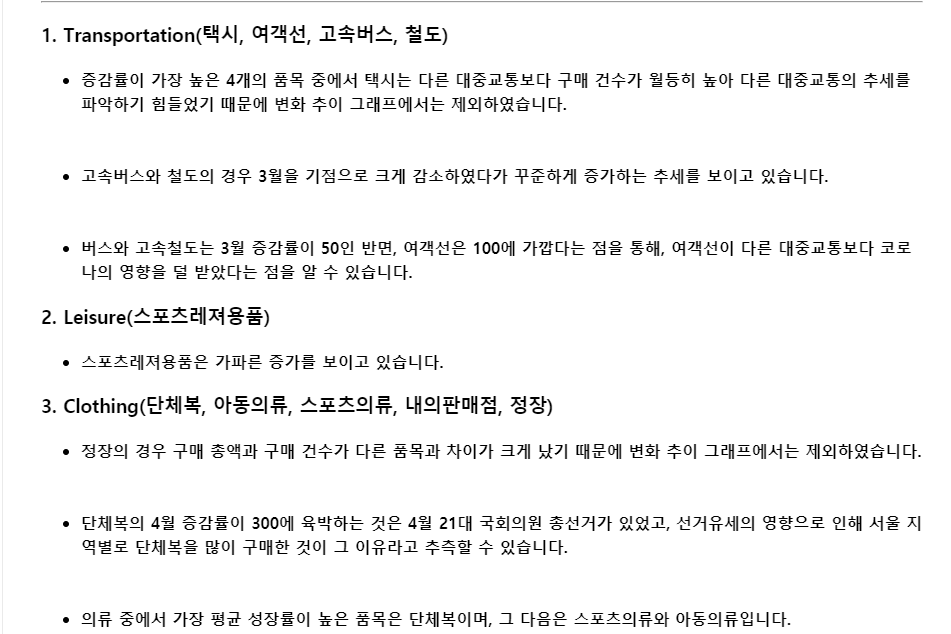 

여기서 내가 드는 생각  
1. Transportation  
여객선의 꾸준한 상승이 한강이나, 여객선이 있는 해변 관광지의 수요가 나날이 늘고있다고 볼 수 있지 않을까?  
택시의 급격한 상승은 (지하철이나 버스보다 택시를 이용하는 수가 많아졌다 or 혼자 여행하는 사람 및 관광지의 교통무지 때문이다.)  
로 볼 수 있지 않을까?  

2. Leisure  
스포츠 레저용품이 정확히 어떤 분류인지를 알아야 한다.  

3. Clothing  
스포츠 의류와 내의 판매 시장의 동일한 폭의 증가가 코로나 이후 사람들로 하여금 운동에 더 많은 시간을 들이지 않았는 지 궁금해졌다.  
예를 들면 유산소 운동인 러닝이나 스쿼시 등의 종목  

# 이 글쓴이는 이 데이터를 보고 사람들이 캠핑을 많이 갔을 것이다 라고 생각하였음! 

## 이를 확인하기 위해 관광지는 잘 안간다는 사실을 증명해야 했다.  
## 따라서 밀집 지역에 방문하지 않는다는 사실을 확인하려고 하였음

밀집지역 : 노래방, 당구장, 사우나  
화원, 영화관, 수족관 기념품점

In [33]:
dense_store = ["노래방","당구장","사우나","화원","영화관","수족관","기념품점"]

dense = card.groupby(by=["receipt_dttm","mrhst_induty_cl_nm"]).salamt.mean()
dense = dense.reset_index()

fpopl = fpopl_origin.groupby(by="base_ymd").popltn_cascnt.mean()
fpopl = fpopl.reset_index()

dense.rename(columns={"receipt_dttm":"date"}, inplace=True)
fpopl.rename(columns={"base_ymd":"date"}, inplace=True)
fpopl.date = pd.to_datetime(fpopl.date, format="%Y%m%d")
fpopl.date = fpopl.date.dt.strftime("%Y-%m-%d")
fpopl.date = pd.to_datetime(fpopl.date, format="%Y-%m-%d")
names = []
corrs12 = []
corrs36 = []

for dns in dense_store:
    X = dense[dense.mrhst_induty_cl_nm==dns]
    
    
    mth12 = X[ (X.date.dt.month==1) |
               (X.date.dt.month==2) ]

    fpopl12 = fpopl[ (fpopl.date.dt.month==1) |
                     (fpopl.date.dt.month==2) ]
    
    tmp = pd.merge(mth12,fpopl12, on="date")

    corr12 = round(np.corrcoef( tmp.salamt.rolling(window=window).mean().dropna().tolist(), 
                                tmp.popltn_cascnt.rolling(window=window).mean().dropna().tolist())[0][1], 2)
    corrs12.append(corr12)
    mth36 = X[ (X.date.dt.month==3) |
               (X.date.dt.month==4) |
               (X.date.dt.month==5) |
               (X.date.dt.month==6) ]

    fpopl36 = fpopl[ (fpopl.date.dt.month==3) |
                     (fpopl.date.dt.month==4) |
                     (fpopl.date.dt.month==5) |
                     (fpopl.date.dt.month==6) ]

    tmp = pd.merge(mth36,fpopl36, on="date")

    corr36 = round(np.corrcoef( tmp.salamt.rolling(window=window).mean().dropna().tolist(), 
                                tmp.popltn_cascnt.rolling(window=window).mean().dropna().tolist())[0][1], 2)
    corrs36.append(corr36)
    
    
    print('유동인구와 {}의 확산기 이전 상관계수 : '.format(dns))
    print(corr12)
    print("유동인구와 {}의 확산기 이후 상관계수 : ".format(dns))
    print(corr36)
    print('===============================')

유동인구와 노래방의 확산기 이전 상관계수 : 
0.89
유동인구와 노래방의 확산기 이후 상관계수 : 
0.46
유동인구와 당구장의 확산기 이전 상관계수 : 
0.85
유동인구와 당구장의 확산기 이후 상관계수 : 
-0.03
유동인구와 사우나의 확산기 이전 상관계수 : 
0.83
유동인구와 사우나의 확산기 이후 상관계수 : 
0.06
유동인구와 화원의 확산기 이전 상관계수 : 
0.86
유동인구와 화원의 확산기 이후 상관계수 : 
0.19
유동인구와 영화관의 확산기 이전 상관계수 : 
0.52
유동인구와 영화관의 확산기 이후 상관계수 : 
-0.19
유동인구와 수족관의 확산기 이전 상관계수 : 
0.51
유동인구와 수족관의 확산기 이후 상관계수 : 
-0.02
유동인구와 기념품점의 확산기 이전 상관계수 : 
0.5
유동인구와 기념품점의 확산기 이후 상관계수 : 
0.11


여기서 드는 생각  
관광지를 안간다는 것은 밀집지역을 안간다는 것이랑 약간은 다른 핀트 아닌가 생각했음  
그래서 가설확인하는 쪽에서 논리가 조금 이상하다는 생각을 했음 

## 시각화

In [34]:
fig  = make_subplots(rows=3,
                     cols=3, 
                     specs=[ [{"secondary_y":True},{"secondary_y":True},{"secondary_y":True}],
                             [{"secondary_y":True},{"secondary_y":True},{"secondary_y":True}],
                             [{},{"secondary_y":True},{}] ],
                     horizontal_spacing=0.07,
                     vertical_spacing= 0.1,
                     subplot_titles = ( 
#     "green:유동인구, blue:일별 매출액<br><b>{} Pearson's r : {}<b>".format(names[0],corrs[0]), 
    "<b>{} Pearson's r <br> 확산기 전 : {} <br>확산기 후 {}<b>".format(dense_store[0],corrs12[0],corrs36[0]),
    "<b>{} Pearson's r <br> 확산기 전 : {} <br>확산기 후 {}<b>".format(dense_store[1],corrs12[1],corrs36[1]), 
    "<b>{} Pearson's r <br> 확산기 전 : {} <br>확산기 후 {}<b>".format(dense_store[2],corrs12[2],corrs36[2]),
    "<b>{} Pearson's r <br> 확산기 전 : {} <br>확산기 후 {}<b>".format(dense_store[3],corrs12[3],corrs36[3]), 
    "<b>{} Pearson's r <br> 확산기 전 : {} <br>확산기 후 {}<b>".format(dense_store[4],corrs12[4],corrs36[4]),
    "<b>{} Pearson's r <br> 확산기 전 : {} <br>확산기 후 {}<b>".format(dense_store[5],corrs12[5],corrs36[5]),"", 
    "<b>{} Pearson's r <br> 확산기 전 : {} <br>확산기 후 {}<b>".format(dense_store[6],corrs12[6],corrs36[6]),
    ""))

row = 2
col = 3
idx = 0
for r in np.arange(1,row+1):
    for c in np.arange(1,col+1):
#         print(names[idx])
        X = dense[dense.mrhst_induty_cl_nm==dense_store[idx]]

        fig.add_trace( 
                go.Scatter(
                        x    = fpopl.date, 
                        y    = fpopl.popltn_cascnt.rolling(window=window).mean(), 
                        mode = "lines",
                        line = dict( 
                            shape     = 'spline', 
                                     smoothing = 1.3,
                                     width     = 2,
                                     color     = "#48DC55" ),
                        name = "유동인구 변화추이",
                        hovertemplate = '<i>유동인구</i>=%{y:,f}'+'명'
            ),
            secondary_y=True, 
            row=int(r), 
            col=int(c)
        )

        
        fig.add_trace( 
                go.Scatter( 
                        x    = X.date, 
                        y    = X.salamt.rolling(window=window).mean(), 
                        mode = "lines",
                        line = dict(
                                    shape     = 'spline', 
                                    smoothing = 1.3, 
                                    width     = 2,
                                    color     = "#5E43EE"),
                        name          = "{}의 매출변화 추이".format(dense_store[idx]),
                        hovertemplate = '<i>구매 총액</i>=%{y:,f}'+'원',
            ),
            secondary_y=False, 
            row=int(r), 
            col=int(c)
        )
        idx = idx + 1
        
X = dense[dense.mrhst_induty_cl_nm==dense_store[6]]

fig.add_trace( 
        go.Scatter(
                x    = fpopl.date, 
                y    = fpopl.popltn_cascnt.rolling(window=window).mean(), 
                mode = "lines",
                line = dict( shape     = 'spline', 
                             smoothing = 1.3,
                             width     = 2,
                             color     = "#48DC55" ),
                name = "유동인구 변화추이",
                hovertemplate = '<i>유동인구</i>=%{y:,f}'+'명'
    ),
    secondary_y=True, 
    row=3, 
    col=2
)
fig.add_trace( 
        go.Scatter( 
                x    = X.date, 
                y    = X.salamt.rolling(window=window).mean(), 
                mode = "lines",
                line = dict(
                            shape     = 'spline', 
                            smoothing = 1.3, 
                            width     = 2,
                            color     = "#5E43EE"),
                name          = "기념품 점의 매출변화 추이",
                hovertemplate = '<i>구매 총액</i>=%{y:,f}'+'원',
    ),
    secondary_y=False, 
    row=3, 
    col=2
)

fig.update_traces(textposition='top center')

# set x, y axis
for i in range(1,4):
    fig.update_yaxes( showticklabels=False, showgrid=False, tickvals = [], ticktext=[""], row=i )
    fig.update_xaxes( showticklabels=False, showgrid=False, tickvals = [], ticktext=[""], row=i )
    
fig.update_yaxes( tickvals = [], ticktext=[""],showticklabels=False, row=6 )
fig.update_yaxes( tickvals = [], ticktext=[""],showticklabels=False, row=6 )
    
fig.update_yaxes(range=[0,1],tickvals=[-1, -0.7, -0.3, 0, 0.3,0.7, 1], ticktext=[-1, -0.7, -0.3, 0, 0.3, 0.7, 1], row=7)
fig.update_xaxes(range=[0,len(names)+1], tickvals = [], ticktext=[""], showticklabels=False, row=7)

# set layout
fig.update_layout(
                height     = 700, 
                width      = 900, 
                showlegend = False,
)

for i in fig['layout']['annotations']:
    i['font'] = dict(size=10)

fig.add_annotation(text=" <br> Blue : 매출액 <br><br><br>  Green : 유동인구", row=3,col=1, font = dict(size=15))

fig.show()

시각화 어떻게 이렇게 하누,, 서로 다른 Y축 설정을 어떻게 하려나.. 시각화 코드 파볼 필요가 있을 듯.. ㅠ  
이 시각화 라이브러리 직관적이고 좋은 것 같음 그래프도 이쁘고,,  

### 음식점은 어떨까? 중분류의 80번이 음식점류인 것 같음

In [35]:
foods = card[card.mrhst_induty_clm_code == str(80)]
foods = foods.groupby(by=["receipt_dttm","mrhst_induty_cl_nm"]).salamt.mean()
foods = foods.reset_index()
fd_range = foods.mrhst_induty_cl_nm.unique().tolist()
foods.rename(columns={"receipt_dttm":"date"}, inplace=True)

fpopl = fpopl_origin.groupby(by="base_ymd").popltn_cascnt.mean()
fpopl = fpopl.reset_index()
fpopl.rename(columns={"base_ymd":"date"}, inplace=True)
fpopl.date = pd.to_datetime(fpopl.date, format="%Y%m%d")
fpopl.date = fpopl.date.dt.strftime("%Y-%m-%d")
fpopl.date = pd.to_datetime(fpopl.date, format="%Y-%m-%d")
fd_corrs12 = []
fd_corrs36 = []

for fd in fd_range:
    X = foods[foods.mrhst_induty_cl_nm==fd]
    
    
    mth12 = X[ (X.date.dt.month==1) |
               (X.date.dt.month==2) ]

    fpopl12 = fpopl[ (fpopl.date.dt.month==1) |
                     (fpopl.date.dt.month==2) ]
    
    tmp = pd.merge(mth12,fpopl12, on="date")

    fd_corr12 = round(np.corrcoef( tmp.salamt.rolling(window=window).mean().dropna().tolist(), 
                                tmp.popltn_cascnt.rolling(window=window).mean().dropna().tolist())[0][1], 2)
    fd_corrs12.append(fd_corr12)
    mth36 = X[ (X.date.dt.month==3) |
               (X.date.dt.month==4) |
               (X.date.dt.month==5) |
               (X.date.dt.month==6) ]

    fpopl36 = fpopl[ (fpopl.date.dt.month==3) |
                     (fpopl.date.dt.month==4) |
                     (fpopl.date.dt.month==5) |
                     (fpopl.date.dt.month==6) ]

    tmp = pd.merge(mth36,fpopl36, on="date")

    fd_corr36 = round(np.corrcoef( tmp.salamt.rolling(window=window).mean().dropna().tolist(), 
                                tmp.popltn_cascnt.rolling(window=window).mean().dropna().tolist())[0][1], 2)
    fd_corrs36.append(fd_corr36)
    
    
    print('유동인구와 {}의 1-2월상관계수 : '.format(fd))
    print(fd_corr12)
    print("유동인구와 {}의 3-6월상관계수 : ".format(fd))
    print(fd_corr36)
    print('===============================')

유동인구와 서양음식의 1-2월상관계수 : 
0.94
유동인구와 서양음식의 3-6월상관계수 : 
0.95
유동인구와 스넥의 1-2월상관계수 : 
0.83
유동인구와 스넥의 3-6월상관계수 : 
0.93
유동인구와 위탁급식업의 1-2월상관계수 : 
0.82
유동인구와 위탁급식업의 3-6월상관계수 : 
0.6
유동인구와 일반한식의 1-2월상관계수 : 
0.93
유동인구와 일반한식의 3-6월상관계수 : 
0.93
유동인구와 일식회집의 1-2월상관계수 : 
0.92
유동인구와 일식회집의 3-6월상관계수 : 
0.95
유동인구와 주점의 1-2월상관계수 : 
0.95
유동인구와 주점의 3-6월상관계수 : 
0.88
유동인구와 중국음식의 1-2월상관계수 : 
0.9
유동인구와 중국음식의 3-6월상관계수 : 
0.92
유동인구와 칵테일바의 1-2월상관계수 : 
0.84
유동인구와 칵테일바의 3-6월상관계수 : 
0.81
유동인구와 갈비전문점의 1-2월상관계수 : 
0.64
유동인구와 갈비전문점의 3-6월상관계수 : 
0.61
유동인구와 한정식의 1-2월상관계수 : 
0.31
유동인구와 한정식의 3-6월상관계수 : 
0.38


In [36]:
fig  = make_subplots(rows  = 3,
                     cols  = 1, 
                     specs = [ [ {} ], [ {} ], [ {} ]  ],
                     vertical_spacing = 0.05,
                     subplot_titles   = ( "<b>확산기 이전과 이후의 음식점의 매출액과 유동인구의 상관관계<b>",
                                          "<b>확산기 이전과 이후의 밀집지역의 매출액과 유동인구의 상관관계<b>",
                                          "<b>관광여행 품목의 매출액과 유동인구 변화 추이<b>")
                    
                    )
# 음식점 상관계수
opacity = 0.7
fig.add_trace(
        go.Scatter(
        
            x  =  np.arange(1,len(fd_corrs12)+1), 
            y  =  fd_corrs12, 
            mode          = "markers+text",
            marker_symbol = "star",
            marker_color  = "#718DF0",
            marker_size   = 13,
            opacity       = opacity,
            text          = fd_range, 
            textfont      = dict(size=10),
            textposition  = "bottom center"
        ), row = 1, 
           col = 1,
)
fig.add_trace(
        go.Scatter(
            x  =  np.arange(1,len(fd_corrs36)+1), 
            y  =  fd_corrs36, 
            mode          = "markers+text",
            marker_symbol = "star",
            marker_color  = "#FF5733",
            marker_size   = 13,
            opacity       = opacity
        ), 
    row = 1, 
    col = 1,
)

# 밀집지역 상관계수
fig.add_trace(
        go.Scatter(
            x  =  np.arange(1,len(corrs12)+1), 
            y  =  corrs12, 
            mode          = "markers+text",
            marker_symbol = "star",
            marker_color  = "#718DF0",
            marker_size   = 13,
            text          = dense_store, 
            textfont      = dict(
                size = 10
            ),
            textposition  = "bottom center",
            opacity       = opacity,
        ), 
    row = 2, 
    col = 1,
)

fig.add_trace(
        go.Scatter(
            x  =  np.arange(1,len(corrs36)+1), 
            y  =  corrs36, 
            mode          = "markers+text",
            marker_symbol = "star",
            marker_color  = "#FF5733",
            marker_size   = 13,
            opacity       = opacity,
        ), 
    row = 2, 
    col = 1,
)




tmp = card[card.mrhst_induty_cl_nm=="관광여행"]

tmp = tmp.groupby(by="receipt_dttm")["salamt"].mean()
tmp = tmp.reset_index()
fig.add_trace( 
        go.Scatter( 
                x    = tmp.receipt_dttm, 
                y    = tmp.salamt.rolling(window=window).mean(), 
                mode = "lines",
                line = dict(
                            shape     = 'spline', 
                            smoothing = 1.3, 
                            width     = 2,
                            color     = "#C43DCA"),
                name          = "관광여행의 매출변화 추이",
                hovertemplate = '<i>구매 총액</i>=%{y:,f}'+'원',
    ),
    row = 3, 
    col = 1
)

for i in range(1,3):
    fig.update_yaxes(range    = [-0.3, 1], 
                     tickvals = [0, 0.3, 0.7, 1], 
                     ticktext = [0, 0.3, 0.7, 1],
                     row = i, 
                     col = 1)

    fig.update_xaxes(tickvals = [], 
                     ticktext = [""], 
                     showticklabels = False, 
                     row = i)
fig.update_xaxes(range = [0,11], 
                 row   = 1, 
                 col   = 1)
    
opacity = 0.3
height = 900
width = 800
fig.update_layout( 
                height     = height, 
                width      = width,
                template   = template,
                hovermode  = "x", 
                showlegend = False,
                shapes=[
                        # 음식점 음영
                        dict(
                            fillcolor = "#F3D7CF",
                            line = dict( width = 0 ),
                            type = "rect",
                            x0   = 0,
                            x1   = len(fd_range)+1,
                            xref = "x1",
                            y0   = 0.837,
                            y1   = 0.93,
                            yref = "paper",
                            opacity = opacity),

                        dict(
                            fillcolor = "#F37859",
                            line = dict( width = 0 ),
                            type = "rect",
                            x0   = 0,
                            x1   = len(fd_range)+1,
                            xref = "x1",
                            y0   =  0.93,
                            y1   =  1,
                            yref = "paper",
                            opacity = opacity),
                        # 밀집지역 음영
                        dict(
                            fillcolor = "#F3D7CF",
                            line = dict( width = 0 ),
                            type = "rect",
                            x0   = 0,
                            x1   = len(dense_store)+5,
                            xref = "x1",
                            y0   = 0.49,
                            y1   = 0.58,
                            yref = "paper",
                            opacity = opacity),

                        dict(
                            fillcolor = "#F37859",
                            line = dict( width = 0 ),
                            type = "rect",
                            x0   = 0,
                            x1   = len(dense_store)+5,
                            xref = "x1",
                            y0   =  0.58,
                            y1   =  0.65,
                            yref = "paper",
                            opacity = opacity)
                ],
    
                )

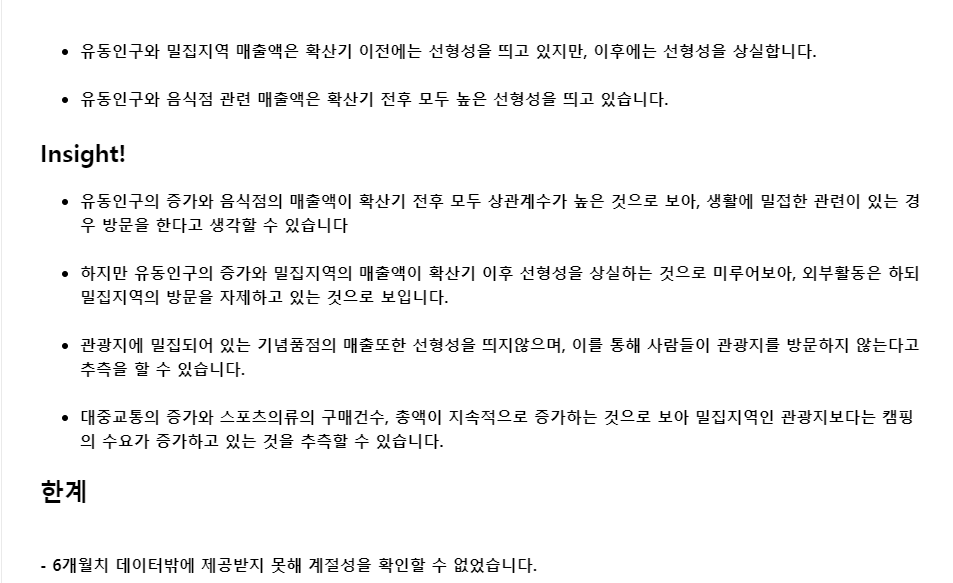 